In [ ]:
%cd drive/My\ Drive/colab/imec

/content/drive/My Drive/colab/imec


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LeakyReLU, Dense, Conv2D


# todo: only grayscale so far
# todo: add multiscale conv

class MLP_conv_dense(Model):
    def __init__(self, n_layers_dense_lower=4, n_layers_dense_upper=2, n_layers_conv=None,
                 n_hidden_conv=None, n_hidden_dense_lower=500, n_hidden_dense_lower_output=2, n_hidden_dense_upper=20,
                 spatial_width=28, n_scales=None, n_temporal_basis=10):
        super(MLP_conv_dense, self).__init__()
        self.mlp = MLP(spatial_width, n_hidden_dense_lower_output, n_layers_dense_lower, n_hidden_dense_lower)
        self.conv1 = MultiConv(n_hidden_conv,n_layers_conv)
        self.conv2 = ConvSeq1x1(n_hidden_dense_upper, n_layers_dense_upper, n_temporal_basis)

    def call(self, x):
        x_mlp = self.mlp(x)
        x_conv = self.conv1(x)
        x = tf.concat([x_mlp,x_conv],-1)
        x = self.conv2(x)
        return x


class MLP(Model):

    def __init__(self, spatial_width, n_hidden_dense_lower_output, n_layers, n_hidden):
        super(MLP, self).__init__()
        self.spatial_width = spatial_width
        self.n_hidden_dense_lower_output = n_hidden_dense_lower_output
        self.mlp = [Dense(n_hidden, activation=LeakyReLU()) for i in range(n_layers - 1)]
        self.mlp.append(Dense(n_hidden_dense_lower_output * spatial_width ** 2, activation=LeakyReLU()))

    def call(self, x):
        x = tf.reshape(x, (tf.shape(x)[0], -1))
        for dense in self.mlp:
            x = dense(x)
        x = tf.reshape(x, (-1, self.spatial_width, self.spatial_width, self.n_hidden_dense_lower_output))
        return x


class ConvSeq1x1(Model):
    def __init__(self, channels, n_layers, n_temporal_basis):
        super(ConvSeq1x1, self).__init__()
        self.conv = [Conv2D(channels, 1, activation=LeakyReLU()) for i in range(n_layers - 1)]
        self.conv.append(Conv2D(n_temporal_basis * 2, 1, activation=LeakyReLU()))

    def call(self, x):
        for c in self.conv:
            x = c(x)
        return x


class MultiConv(Model):
    def __init__(self, channels, n_layers):
        super(MultiConv, self).__init__()
        self.conv = [Conv2D(channels, 3, padding='same', activation=LeakyReLU()) for i in range(n_layers)]

    def call(self, x):
        for c in self.conv:
            x = c(x)
        return x

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
#from regression import MLP_conv_dense
import matplotlib.pyplot as plt

tfd = tfp.distributions

logit_np = lambda u: tf.convert_to_tensor(np.log(u / (1. - u)),dtype=tf.float32)
logit = lambda u: tf.math.log(u / (1.-u))




class DiffusionModel():
    def __init__(self, spatial_width=28,
                 trajectory_length=1000,
                 n_temporal_basis=10,
                 n_hidden_dense_lower=500,
                 n_hidden_dense_lower_output=2,
                 n_hidden_dense_upper=20,
                 n_hidden_conv=20,
                 n_layers_conv=4,
                 n_layers_dense_lower=4,
                 n_layers_dense_upper=2,
                 n_t_per_minibatch=1,
                 n_scales=None,  # 1
                 step1_beta=0.001,
                 uniform_noise=0, ):

        self.n_t_per_minibatch = n_t_per_minibatch
        self.spatial_width = np.int16(spatial_width)
        self.n_temporal_basis = n_temporal_basis
        self.trajectory_length = trajectory_length
        self.uniform_noise = uniform_noise
        self.n_colors = 1

        self.model = MLP_conv_dense(n_layers_dense_lower, n_layers_dense_upper, n_layers_conv, n_hidden_conv,
                                    n_hidden_dense_lower,
                                    n_hidden_dense_lower_output, n_hidden_dense_upper, spatial_width, n_scales,
                                    n_temporal_basis)

        self.temporal_basis = self.generate_temporal_basis(trajectory_length, n_temporal_basis)
        self.beta_arr = self.generate_beta_arr(step1_beta)

        starter_learning_rate = 1e-3
        end_learning_rate = 1e-5
        decay_steps = 120000
        learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
            starter_learning_rate,
            decay_steps,
            end_learning_rate,
            power=0.9)

        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate_fn)
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.seed = tfp.util.SeedStream(123, salt="random_beta")

    def get_mu_sigma(self, X_noisy, t):
        """
        Generate mu and sigma for one step in the reverse trajectory,
        starting from a minibatch of images X_noisy, and at timestep t.
        """
        Z = self.model(X_noisy)
        mu_coeff, beta_coeff = self.temporal_readout(Z, t)
        # reverse variance is perturbation around forward variance
        beta_forward = self.get_beta_forward(t)
        # make impact of beta_coeff scaled appropriately with mu_coeff
        beta_coeff_scaled = beta_coeff / tf.math.sqrt(tf.cast(self.trajectory_length, tf.float32))
        beta_reverse = tf.math.sigmoid(beta_coeff_scaled + logit(beta_forward))
        # # reverse mean is decay towards mu_coeff
        # mu = (X_noisy - mu_coeff)*T.sqrt(1. - beta_reverse) + mu_coeff
        # reverse mean is a perturbation around the mean under forward
        # process

        # # DEBUG -- use these lines to test objective is 0 for isotropic Gaussian model
        # beta_reverse = beta_forward
        # mu_coeff = mu_coeff*0

        mu = X_noisy * tf.math.sqrt(1. - beta_forward) + mu_coeff * tf.math.sqrt(beta_forward)
        sigma = tf.math.sqrt(beta_reverse)
        return mu, sigma


    def generate_beta_arr(self, step1_beta):
        """
        Generate the noise covariances, beta_t, for the forward trajectory.
        """
        # lower bound on beta
        min_beta_val = 1e-6
        min_beta_values = np.ones((self.trajectory_length,)) * min_beta_val
        min_beta_values[0] += step1_beta
        min_beta = tf.convert_to_tensor(min_beta_values, dtype=tf.float32)

        # baseline behavior of beta with time -- destroy a constant fraction
        # of the original data variance each time step
        # NOTE 2 below means a fraction ~1/T of the variance will be left at the end of the
        # trajectory
        beta_baseline = 1. / np.linspace(self.trajectory_length, 2., self.trajectory_length)
        beta_baseline_offset = logit_np(beta_baseline)
        # and the actual beta_t, restricted to be between min_beta and 1-[small value]
        beta_arr = tf.math.sigmoid(beta_baseline_offset)
        beta_arr = min_beta + beta_arr * (1 - min_beta - 1e-5)
        beta_arr = tf.reshape(beta_arr,(self.trajectory_length, 1))
        return beta_arr


    def generate_temporal_basis(self, trajectory_length, n_basis):
        """
        Generate the bump basis functions for temporal readout of mu and sigma.
        """
        temporal_basis = np.zeros((trajectory_length, n_basis))
        xx = np.linspace(-1, 1, trajectory_length)
        x_centers = np.linspace(-1, 1, n_basis)
        width = (x_centers[1] - x_centers[0]) / 2.
        for ii in range(n_basis):
            temporal_basis[:, ii] = np.exp(-(xx - x_centers[ii]) ** 2 / (2 * width ** 2))
        temporal_basis /= np.sum(temporal_basis, axis=1).reshape((-1, 1))
        temporal_basis = tf.convert_to_tensor(temporal_basis,dtype=tf.float32)
        return temporal_basis

    def temporal_readout(self, Z, t):
        """
        Go from the top layer of the multilayer perceptron to coefficients for
        mu and sigma for each pixel.
        Z contains coefficients for spatial basis functions for each pixel for
        both mu and sigma.
        """
        n_images = Z.shape[0]
        t_weights = self.get_t_weights(t)
        coeff_weights = tf.matmul(tf.transpose(self.temporal_basis), t_weights)
        Z = tf.reshape(Z,list(Z.shape[:-1])+[2,-1])
        concat_coeffs = tf.squeeze(tf.matmul(Z,coeff_weights))
        mu_coeff = tf.expand_dims(concat_coeffs[:, :, :, 0],-1)
        beta_coeff = tf.expand_dims(concat_coeffs[:, :, :, 1],-1)
        return mu_coeff, beta_coeff

    def get_t_weights(self, t):
        """
        Generate vector of weights allowing selection of current timestep.
        (if t is not an integer, the weights will linearly interpolate)
        """
        n_seg = self.trajectory_length
        t_compare = tf.reshape(tf.range(n_seg,dtype=tf.float32), (1,n_seg))
        diff = abs(t - t_compare)
        t_weights = tf.reduce_max(tf.concat([tf.reshape(-diff+1,(n_seg,1)),tf.zeros(((n_seg, 1)))],axis=1),axis=1)
        return tf.reshape(t_weights,(-1,1))

    def get_beta_forward(self, t):
        """
        Get the covariance of the forward diffusion process at timestep
        t.
        """
        t_weights = self.get_t_weights(t)
        return tf.matmul(tf.transpose(t_weights), self.beta_arr)

    def get_beta_full_trajectory(self):
        """
        Return the cumulative covariance from the entire forward trajectory.
        """
        alpha_arr = 1. - self.beta_arr
        beta_full_trajectory = 1. - tf.math.exp(tf.math.reduce_sum(tf.math.log(alpha_arr)))
        return beta_full_trajectory

    def generate_forward_diffusion_sample(self, X_noiseless):
        """
        Corrupt a training image with t steps worth of Gaussian noise, and
        return the corrupted image, as well as the mean and covariance of the
        posterior q(x^{t-1}|x^t, x^0).
        """

        #n_images = X_noiseless.shape[0].astype('int16')
        # choose a timestep in [1, self.trajectory_length-1].
        # note the reverse process is fixed for the very
        # first timestep, so we skip it.
        # TODO for some reason random_integer is missing from the Blocks
        # theano random number generator.
        t = tf.math.floor(tfd.Uniform(low=1,high=self.trajectory_length).sample((1,1)))
        t_weights = self.get_t_weights(t)

        N = tfd.Normal(loc=0,scale=1).sample(X_noiseless.shape)

        # noise added this time step
        beta_forward = self.get_beta_forward(t)
        # decay in noise variance due to original signal this step
        alpha_forward = 1. - beta_forward
        # compute total decay in the fraction of the variance due to X_noiseless
        alpha_arr = 1. - self.beta_arr

        alpha_cum_forward_arr = tf.reshape(tf.math.cumprod(alpha_arr), (self.trajectory_length, 1))

        alpha_cum_forward = tf.matmul(tf.transpose(t_weights), alpha_cum_forward_arr)
        # total fraction of the variance due to noise being mixed in
        beta_cumulative = 1. - alpha_cum_forward
        # total fraction of the variance due to noise being mixed in one step ago
        beta_cumulative_prior_step = 1. - alpha_cum_forward / alpha_forward

        # generate the corrupted training data
        U = tfd.Uniform().sample(X_noiseless.shape)
        X_uniformnoise = X_noiseless + ( U - tf.constant(0.5, dtype=tf.float32)) * tf.constant(
            self.uniform_noise, dtype=tf.float32)

        X_noisy = X_uniformnoise * tf.math.sqrt(alpha_cum_forward) + N * tf.math.sqrt(1. - alpha_cum_forward)

        # compute the mean and covariance of the posterior distribution
        mu1_scl = tf.math.sqrt(alpha_cum_forward / alpha_forward)
        mu2_scl = 1. / tf.math.sqrt(alpha_forward)
        cov1 = 1. - alpha_cum_forward / alpha_forward
        cov2 = beta_forward / alpha_forward
        lam = 1. / cov1 + 1. / cov2
        mu = (
                     X_uniformnoise * mu1_scl / cov1 +
                     X_noisy * mu2_scl / cov2
             ) / lam
        sigma = tf.math.sqrt(1. / lam)
        sigma = tf.reshape(sigma, (1, 1, 1, 1))

        return X_noisy, t, mu, sigma

    def get_negL_bound(self, mu, sigma, mu_posterior, sigma_posterior):
        """
        Compute the lower bound on the log likelihood, as a function of mu and
        sigma from the reverse diffusion process, and the posterior mu and
        sigma from the forward diffusion process.
        Returns the difference between this bound and the log likelihood
        under a unit norm isotropic Gaussian. So this function returns how
        much better the diffusion model is than an isotropic Gaussian.
        """

        # the KL divergence between model transition and posterior from data
        KL = (tf.math.log(sigma) - tf.math.log(sigma_posterior)
              + (sigma_posterior ** 2 + (mu_posterior - mu) ** 2) / (2 * sigma ** 2)
              - 0.5)
        # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
        H_startpoint = (0.5 * (1 + tf.math.log(2. * np.pi))) + 0.5 * tf.math.log(self.beta_arr[0])
        H_endpoint = (0.5 * (1 + tf.math.log(2. * np.pi))) + 0.5 * tf.math.log(
            self.get_beta_full_trajectory())
        H_prior = (0.5 * (1 + tf.math.log(2. * np.pi))) + 0.5 * tf.math.log(1.)
        negL_bound = KL * self.trajectory_length + H_startpoint - H_endpoint + H_prior
        # the negL_bound if this was an isotropic Gaussian model of the data
        negL_gauss = (0.5 * (1 + tf.math.log(2. * np.pi))) + 0.5 * tf.math.log(1.)
        negL_diff = negL_bound - negL_gauss
        L_diff_bits = negL_diff / tf.math.log(2.)
        L_diff_bits_avg = tf.math.reduce_mean(L_diff_bits) * self.n_colors
        return L_diff_bits_avg

    def cost(self, X_noiseless):
        """
        Compute the lower bound on the log likelihood, given a training minibatch.
        This will draw a single timestep and compute the cost for that timestep only.
        """
        cost = 0.
        for ii in range(self.n_t_per_minibatch):
            cost += self.cost_single_t(X_noiseless)
        return cost / self.n_t_per_minibatch

    def cost_single_t(self, X_noiseless):
        """
        Compute the lower bound on the log likelihood, given a training minibatch, for a single
        randomly chosen timestep.
        """
        X_noisy, t, mu_posterior, sigma_posterior = \
            self.generate_forward_diffusion_sample(X_noiseless)
        mu, sigma = self.get_mu_sigma(X_noisy, t)
        negL_bound = self.get_negL_bound(mu, sigma, mu_posterior, sigma_posterior)
        return negL_bound

    def internal_state(self, X_noiseless):
        """
        Return a bunch of the internal state, for monitoring purposes during optimization.
        """
        X_noisy, t, mu_posterior, sigma_posterior = \
            self.generate_forward_diffusion_sample(X_noiseless)
        mu, sigma = self.get_mu_sigma(X_noisy, t)
        mu_diff = mu - mu_posterior
        logratio = tf.math.log(sigma / sigma_posterior)
        return [mu_diff, logratio, mu, sigma, mu_posterior, sigma_posterior, X_noiseless, X_noisy]


    def train(self, train_ds, epochs=10):

        for epoch in range(epochs):
            self.train_loss.reset_states()

            for images in train_ds:
                X_noisy, t, mu_posterior, sigma_posterior = \
                    self.generate_forward_diffusion_sample(images)
                self.train_step(X_noisy, t, mu_posterior, sigma_posterior)
            
            if epoch%100==0:
                self.save(f'weights/try_{epoch}')
            print(epoch)
            print(self.train_loss.result())


    @tf.function
    def train_step(self, X_noisy, t, mu_posterior, sigma_posterior):
        with tf.GradientTape() as tape:
            # training=True is only needed if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            mu, sigma = self.get_mu_sigma(X_noisy, t)
            loss = self.get_negL_bound(mu, sigma, mu_posterior, sigma_posterior)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.train_loss(loss)


    def save(self,path='weights/try1'):
        self.model.save_weights(path)

    def load(self,path='weights/try1'):
        self.model.load_weights(path)

    def generate_samples(self,
                         n_samples=36,
                         num_intermediate_plots=4):
        """
        Run the reverse diffusion process (generative model).
        """
        # use the same noise in the samples every time, so they're easier to
        # compare across learning

        spatial_width = self.spatial_width
        n_colors = self.n_colors

        # set the initial state X^T of the reverse trajectory
        Xmid = tfd.Normal(loc=0,scale=1).sample((n_samples,spatial_width,spatial_width,n_colors),seed=self.seed())


        for t in range(self.trajectory_length - 1, 0, -1):
            Xmid = self.diffusion_step(Xmid, t)
            if np.mod(self.trajectory_length - t,
                      int(np.ceil(self.trajectory_length / (num_intermediate_plots + 2.)))) == 0:
                fig = plt.figure(figsize=(7, 7))
                for i in range(Xmid.shape[0]):
                    plt.subplot(7, 7, i + 1)
                    plt.imshow(Xmid[i, :, :, 0], cmap='gray')
                    plt.axis('off')
                plt.show()

        X0 = Xmid
        fig = plt.figure(figsize=(7, 7))
        for i in range(X0.shape[0]):
            plt.subplot(7, 7, i + 1)
            plt.imshow(X0[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()

    def diffusion_step(self, Xmid, t):
        """
        Run a single reverse diffusion step
        """
        mu, sigma = self.get_mu_sigma(Xmid, np.array([[t]]))
        Xmid = mu + sigma * tfd.Normal(loc=0,scale=1).sample(Xmid.shape)
        return Xmid

0
tf.Tensor(-0.51887935, shape=(), dtype=float32)
1
tf.Tensor(-0.73860514, shape=(), dtype=float32)
2
tf.Tensor(-0.8198277, shape=(), dtype=float32)
3
tf.Tensor(-2.3322098, shape=(), dtype=float32)
4
tf.Tensor(-3.3698285, shape=(), dtype=float32)
5
tf.Tensor(-1.4029617, shape=(), dtype=float32)
6
tf.Tensor(-3.6209729, shape=(), dtype=float32)
7
tf.Tensor(0.23510972, shape=(), dtype=float32)
8
tf.Tensor(53.929035, shape=(), dtype=float32)
9
tf.Tensor(-2.0425067, shape=(), dtype=float32)
10
tf.Tensor(1.3925607, shape=(), dtype=float32)
11
tf.Tensor(-2.4032848, shape=(), dtype=float32)
12
tf.Tensor(-1.0448204, shape=(), dtype=float32)
13
tf.Tensor(-2.7597406, shape=(), dtype=float32)
14
tf.Tensor(-1.8877119, shape=(), dtype=float32)
15
tf.Tensor(-2.0574334, shape=(), dtype=float32)
16
tf.Tensor(-3.51387, shape=(), dtype=float32)
17
tf.Tensor(-0.20265985, shape=(), dtype=float32)
18
tf.Tensor(-2.725903, shape=(), dtype=float32)
19
tf.Tensor(-3.0449147, shape=(), dtype=float32)
20
tf.Tensor

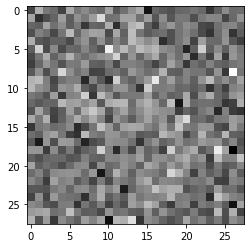

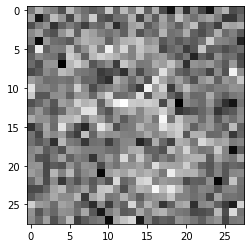

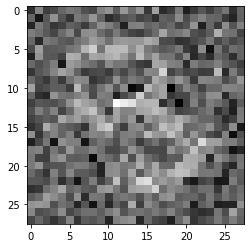

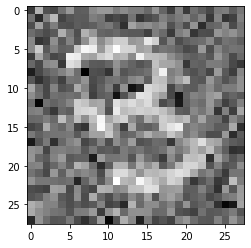

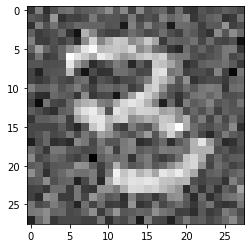

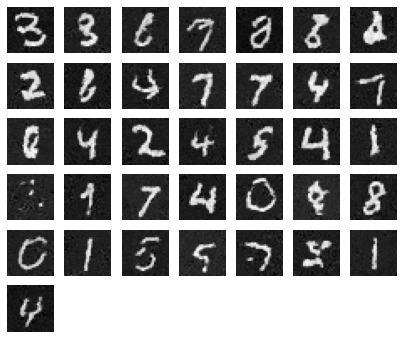

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
#from model import DiffusionModel
import numpy as np

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

n_colors = 1
spatial_width = 28
batch_size = 500
lr=1e-3

model = DiffusionModel()

def _preprocess(sample):
    image = (tf.cast(sample['image'], tf.float32) -127.5) / 127.5
    return image




train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))

eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

#model.load()
model.train(train_dataset,epochs=1000)
model.save('weoghts/try3')
model.generate_samples()


